# JUAS'22 Accelerator Design Topic III: Lattice Design

The goal of this mini-workshop is to apply the knowledge gained during this school to a realistic problem. The task is to design a particle accelerator with certain specifications and boundary conditions. The idea is to gain experience how such a big task is tackled and organised.
There are ten groups of three persons each. We offer three topics, that look at the same problem from slightly different angles and with different emphasis.

**Scope: design a top factory for precision measurements.**
Design a particle collider (the *JUAS Collider*) for precision measurements of the top quark mass at the $t\bar{t}$-threshold.
The circumference must not exceed 100 km and the maximum synchrotron radiation power is limited to 50 MW per beam.
Per year at least 100000 $t\bar{t}$ pairs should be produced for sufficient statistics.

*Hint:* Should your calculation crash, it is useful to restart the notebook kernel and re-run all previous cells ("Cell $\rightarrow$ Run All Above").

In [1]:
import numpy as np

import sys, os

from cpymad.madx import Madx
from matplotlib import pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('ticks',
              {'grid.linestyle': 'none', 'axes.edgecolor': '0',
               'axes.linewidth': 1.2, 'legend.frameon': True,
               'xtick.direction': 'out', 'ytick.direction': 'out',
               'xtick.top': True, 'ytick.right': True,
              })

In [2]:
madx = Madx(stdout=True)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.07.00  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2021.05.03               +
  + Execution date: 2022.02.04 14:59:29      +
  ++++++++++++++++++++++++++++++++++++++++++++


*Comment:* You find the MAD-X documentation here: https://mad.web.cern.ch/mad/

## Exercise summary

1) Design basic cell according to beam requirements<br />
2) Implement a MAD-X model of your basic cell, close the ring and calculate SR integrals and equilibrium beam parameters<br />
3) Include dispersion suppressors and straight sections to your model and match optics<br />
4) Include RF cavities and calculate equilibrium beam parameters with MAD-X<br />
5) Optional: include mini-beta insertion and match optics.

### Note: this notebook embeds the structure to solve the exercises. 

$\implies$ You need to fill in the gaps indicated with "[...]" to make it work.

Also note that, at the end of the course, you are expected to present a well-prepared set of slides during the examination, suitable to show to the other groups working on different topics. You may use this notebook to compute all the results, however, the notebook itself should <b><u>not</u></b> be used in the presentation.

## 1. Assume following boundary conditions

- Beam energy: $E=175$ GeV<br />
- Horizontal equilibrium emittance: $\epsilon_x = 1.3$ nm rad<br />
- Damping partition number: $J_x =1$<br />
- A maximum circumference of 100 km<br />
- Maximum synchrotron radiation power: $P = 50$ MW per beam<br />
- The basic cell should have the same phase advance in both planes.<br />

## 2. Design of basic arc cell

### <span style="color:blue;">a) What lattice type do you choose, and why?</span>

We should dessign a FODO cell
- Less expensive: There are "few" elements
- Top quark is very energetic, and so we need as many dipole magnets as possible (very big beam rigidity needed). Ideally we would need only dipoles, but some focusing is needed and it can be achieved with quadrupoles --> FODO
- FODO only requires one focusing and defocusing quadrupoles, and in between we can put whatever we want: Bending dipoles.
- Other dessigns are optimized for chromaticity correction and so many quadrupoles are needed - therefore less space for dipoles.

### <span style="color:blue;">b) What phase advance per cell do you choose, and why?</span>

Precisión colliders requiere leptons (elementary particle itself) to collide and not hadrons (which are "made of" many sub-particles). Therefore, providing a 175GeV energy to electrons will allow us to make better profit of that energy, i.e our mesurement will be more precise. 

In [3]:
# phase advance per cell in radian
mu_x = np.pi/2
mu_y = np.pi/2

### <span style="color:blue;">c) Think  about  the  layout  of  your  basic  cell:  cell  length,  length  of  magnetic  elements,  dipole  filling factor.</span>

*Hint:*  Start with a cell length in the range from 50 m to 60 m.

In [4]:
Lcell = 60  # cell length in m
LB    = 12  # length of bending magnets in m
LQ    = 1  # length of quadrupole magnets in m
LS    = 1  # length of sextupole magnets in m - to be placed after quads because dispersion is longer and therefore the correction is more effective.
# This configuration leaves only cm of drifts between magnets - could be an issue 
# 48/60 = 0.80 filling factor

### <span style="color:blue;">d) Calculate the bending angle for your dipoles in order to match the required equilibrium emittance.</span>

The equilibrium emittance can be approximately calculated using following equation:
$$\epsilon_x = %\frac{C_{\text{q}}}{J_x} \gamma^2\theta^3 \frac{\rho^2}{l_{\text{B}^3}} \langle\mathcal{H}\rangle = 
\frac{C_{\text{q}}}{J_x} \gamma^2\theta^3 F$$
$C_{\text{q}} = \frac{55}{32\sqrt{3}}\frac{\hbar c}{m_0c^2}=3.832\times10^{-13}$ m, $J_x\approx 1$ is the damping partition number, $\gamma$ the Lorentz factor, and $\theta$ the bending angle of all dipole magnets in a half-cell. For a FODO cell with phase advance $\mu$ the factor $F$ can be written as 
$$F_{\text{FODO}} = \frac{1}{2 \sin\mu} \frac{5+3\cos\mu}{1-\cos\mu} \frac{L}{l_{\text{B}}}.$$
$L$ is the cell length and $l_{\text{B}}$ is the length of all dipole magnets in the cell.

In [5]:
epsilon_x = 1.3e-9 # m rad
J_x = 1
C_q = 3.832e-13 # m
gamma_L = 175/0.000511

F   = (5+3*np.cos(mu_x))*Lcell/(2*np.sin(mu_x))/(1-np.cos(mu_x))/LB
THB = ((epsilon_x * J_x)/( F*C_q*gamma_L*gamma_L ))**(1./3.) # Theta bending
THB

0.0013226893212050178

### <span style="color:blue;">e) Calculate the quadrupole strength $k_1$ using </span>
$$\sin(\mu/2) = \frac{L}{4f} \qquad \text{and}\qquad \frac{1}{f} = k_1 L_{\text{Q}},$$
where $L_Q$ is the length of the quadrupole magnets.

In [6]:
invf = np.sin(mu_x/2)*4/Lcell
k1 = invf/LQ
k1 #1/m^2

0.04714045207910316

In [7]:
g = k1/0.3*175
g # [T/m] -- Normal conducting? If it was too high, we would have to make them longer

27.498597046143512

### <span style="color:blue;">f) Define the elements and the basic cell in MAD-X</span>

In [8]:
inputstring = f'''
    LB = {LB};       ! length of bending magnets in m
    LQ = {LQ};       ! length of quadrupoles in m 
    LS = {LS};       ! length of sextupoles in m 
    Lcell = {Lcell}; ! length of basic cell in m
'''
madx.input(inputstring)

True

In [9]:
madx.input('value, Lcell;')

lcell              =                 60 ;


True

In [10]:
# For when we want to add the drifts
N_drift = 8
L_drift = (Lcell - 2. * LQ - 2. * LS - 4. * LB) / N_drift
# Add N_drifts of length L_drift 
L_drift

1.0

In [11]:
inputstring = f'''
    THB = {THB};
!    Ldrift = {L_drift}

    K1QF = {k1};
    K1QD = {-k1};
    
    K2SF = 0;
    K2SD = 0;
'''
madx.input(inputstring)

True

Definition of the elements:

In [12]:
madx.input('''
    MB : SBEND, L:=LB, ANGLE:=THB; 

    MQF: quadrupole, L=LQ, K1:=K1QF;
    halfMQF: quadrupole, L:=.5*LQ, K1:=K1QF; 
    MQD: quadrupole, L=LQ, K1:=K1QD;
    halfMQD: quadrupole, L:=.5*LQ, K1:=K1QD;

    MSF: sextupole, L=LS, K2:=K2SF;
    MSD: sextupole, L=LS, K2:=K2SD; 
''')

True

Sequence definition of arc cell:

*Hint:* Cut the first quadrupole in half (i.e. define quadrupoles with half the length) and put one at the beginning and one at the end of your sequence. This gives you a symmetric structure.

In [13]:
madx.input('''
JC_fodo_arc : SEQUENCE, REFER=centre, L=Lcell;
    MQF1: halfMQF, at= .25*LQ;
    MSF1: MSF, at= .5 *LQ + .5*LS+1.0;
    MB1: MB, at= .5 *LQ + 1.0*LS + .5*LB + 2.0;
    MB2: MB, at= .5 *LQ + 1.0*LS + 1.5*LB + 3.0;
    MQD1: MQD, at=1.0 *LQ + 1.0*LS + 2.0*LB + 4.0;
    MSD1: MSD, at=1.5 *LQ + 1.5*LS + 2.0*LB + 5.0;
    MB3: MB, at=1.5 *LQ + 2.0*LS + 2.5*LB + 6.0;
    MB4: MB, at=1.5 *LQ + 2.0*LS + 3.5*LB + 7.0;
    MQF2: halfMQF, at=1.75*LQ + 2.0*LS + 4.0*LB + 8.0; 
ENDSEQUENCE;
''')

True

Define the phase advance of the basic cell in MAD-X:

In [14]:
# Tunes in MAD-X are given in units of 2 pi

tuneArcCell_X = np.pi/2.0 + 0.01
tuneArcCell_Y = np.pi/2.0 + 0.001

madx.input(f'''
    tuneArcCell_X = {tuneArcCell_X};
    tuneArcCell_Y = {tuneArcCell_Y};
''')

True

Set up of MAD-X environment:

In [15]:
ENERGY = 150
madx.input(f'ENERGY = {ENERGY};')

True

In [16]:
madx.command.beam(particle='electron', energy='ENERGY')

True

In [17]:
madx.use(sequence='JC_fodo_arc')

In [18]:
madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                60                 -0    1.360235459e-05        271.1396019 

                q1                dq1            betxmax              dxmax 
      0.2464614675      -0.3112904067        101.5789295        0.218872355 

             dxrms             xcomax             xcorms                 q2 
      0.1742484977                  0                  0       0.2464591866 

               dq2            betymax              dymax              dyrms 
     -0.3112921484        100.3894801                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

### <span style="color:blue;">Check the tunes `q1` and `q2` in the TWISS summary table. Do they fit your expectation?</span>

### <span style="color:blue;">g) Match the phase advance of your basic arc cell</span>

In [19]:
madx.input('''
match, sequence = JC_fodo_arc;
    GLOBAL, Q1=0.25+0.00001;
    GLOBAL, Q2=0.25+0.00001;
    VARY, NAME= K1QF, STEP=0.000001;
    VARY, NAME= K1QD, STEP=0.000001;
    LMDIF, CALLS=50, TOLERANCE=1e-8;//method adopted 
endmatch;
''')

START MATCHING

number of sequences: 1
sequence name: jc_fodo_arc
number of variables:    2
user given constraints: 1
total constraints:      2

START LMDIF:

Initial Penalty Function =   0.25200359E-02


call:       4   Penalty function =   0.77185671E-07
call:       7   Penalty function =   0.73603537E-16
 ++++++++++ LMDIF ended: converged successfully
call:       7   Penalty function =   0.73603537E-16

MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------
Global constraint:         q1           4     2.50010000E-01     2.50010001E-01     3.49785656E-17
Global constraint:         q2           4     2.50010000E-01     2.50010001E-01     3.86249715E-17


Final Penalty Function =   7.36035370e-17





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
-----------------------------------------------------------

True

Check the matching result by running the twiss command:

In [20]:
twiss=madx.twiss(centre=True)

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                60                 -0    1.328326174e-05        274.3769567 

                q1                dq1            betxmax              dxmax 
      0.2500100006      -0.3183107433        102.0232718        0.214621282 

             dxrms             xcomax             xcorms                 q2 
       0.170529498                  0                  0       0.2500100006 

               dq2            betymax              dymax              dyrms 
     -0.3183146664        102.0235481                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

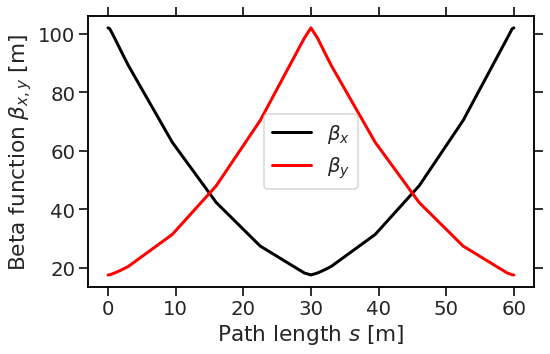

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='red')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m]')
plt.legend();

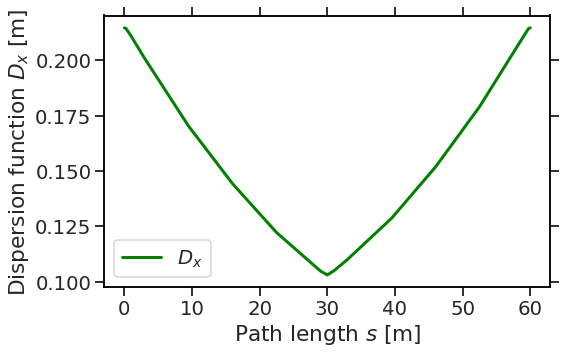

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['Dx'], label=r'$D_x$', color='green')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Dispersion function $D_x$ [m]')
plt.legend();

#### Calculate minimum and maximum beta function of your cell analytically

### <span style="color:blue;">Compare the maximum and minimum values of beta functions of MAD-X to the analytically calculated values. </span>
    
For a FODO cell (symmetrical disposition, beginning and end point middle of focusing quadrupole), the expression for the minimum and maximum optical beta function is given by:

\begin{equation}
\hat{\beta} = \frac{1+\sin{\mu/2}}{\sin{\mu}}\cdot L \hspace{1cm} \text{and} \hspace{1cm}
\check{\beta} = \frac{1-\sin{\mu/2}}{\sin{\mu}} \cdot L 
\end{equation}

In [23]:
beta_max = Lcell * (1. + np.sin(.5 * mu_x)) / np.sin(mu_x)
beta_min = Lcell * (1. - np.sin(.5 * mu_x)) / np.sin(mu_x)

print('[m] Beta max:\t', beta_max, '\t', twiss['betx'].max(), '\t error: ', (beta_max - twiss['betx'].max()) / twiss['betx'].max())
print('[m] Beta min:\t', beta_min, '\t', twiss['betx'].min(), '\t error: ', (beta_min - twiss['betx'].min()) / twiss['betx'].min())

[m] Beta max:	 102.42640687119285 	 102.0232718218291 	 error:  0.0039514028727463246
[m] Beta min:	 17.573593128807154 	 17.641054666353163 	 error:  -0.0038241215631330053


Compare the maximum and minimum values of the dispersion function of MAD-X to the analytically calculated values. They are given by: $$\hat{D} = \frac{L^2}{\rho}\frac{(1+\frac{1}{2}\sin{(\mu/2)})}{4\sin^2{(\mu/2)}} \text{ and } \check{D} = \frac{L^2}{\rho}\frac{(1-\frac{1}{2}\sin{(\mu/2)})}{4\sin^2{(\mu/2)}}$$

In [24]:
rho = LB/np.arcsin(THB)

D_max = Lcell**2.0 / rho  * (1. + .5*np.sin(mu_x * .5)) / (4. * np.sin(mu_x * .5)**2)
D_min = Lcell**2.0 / rho  * (1. - .5*np.sin(mu_x * .5)) / (4. * np.sin(mu_x * .5)**2)

print('Disp max:\t', D_max, '\t', twiss['dx'].max(), '\t error: ', (D_max - twiss['dx'].max()) / twiss['dx'].max())
print('Disp min:\t', D_min, '\t', twiss['dx'].min(), '\t error: ', (D_min - twiss['dx'].min()) / twiss['dx'].min())

Disp max:	 0.26854967061774726 	 0.2146212819728721 	 error:  0.2512723256013895
Disp min:	 0.12825724144656328 	 0.10301608363713177 	 error:  0.24502152400145627


The relative error is $<1\%$ for the $\beta$ max and min.
It is higher for the dispersion, around $25\%$.
Error comes from the fact that analytical expressions come from the thin lens approximation.

### <span style="color:blue;">h) Match the chromaticity of your basic arc cell to zero.</span>

Observe the chromaticities `dq1` and `dq2` in the recent Twiss summary table. What does this mean? How can you correct this?

In [25]:
madx.input('''
match, sequence = JC_fodo_arc;
    GLOBAL, dq1=0;
    GLOBAL, dq2=0;
    VARY, NAME= K2SF, STEP=0.0000001;
    VARY, NAME= K2SD, STEP=0.0000001;
    LMDIF, CALLS=200, TOLERANCE=1e-6;//method adopted 
endmatch;
''')

START MATCHING

number of sequences: 1
sequence name: jc_fodo_arc
number of variables:    2
user given constraints: 1
total constraints:      2

START LMDIF:

Initial Penalty Function =   0.20264596E+00


call:       4   Penalty function =   0.74870153E-25
 ++++++++++ LMDIF ended: converged successfully
call:       4   Penalty function =   0.74870153E-25

MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------
Global constraint:         dq1          4     0.00000000E+00    -2.28543009E-13     5.22319069E-26
Global constraint:         dq2          4     0.00000000E+00     1.50460115E-13     2.26382463E-26


Final Penalty Function =   7.48701532e-26





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
------------------------------------------

True

--------------------------------------
k2sf                      2.61262e-01  0.00000e+00 -1.00000e+20  1.00000e+20
k2sd                     -5.00391e-01  0.00000e+00 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   7.48701532e-26


In [26]:
twiss=madx.twiss(centre=True)

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                60                 -0    1.328326174e-05        274.3769567 

                q1                dq1            betxmax              dxmax 
      0.2500100006   -2.285430089e-13        102.0232718        0.214621282 

             dxrms             xcomax             xcorms                 q2 
       0.170529498                  0                  0       0.2500100006 

               dq2            betymax              dymax              dyrms 
   1.504601152e-13        102.0235481                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

Have a look at the optics again. 

### <span style="color:blue;">Can you explain why the sextupole strengths for the 'defocusing' sextupole are larger than for the 'focusing' one?</span>

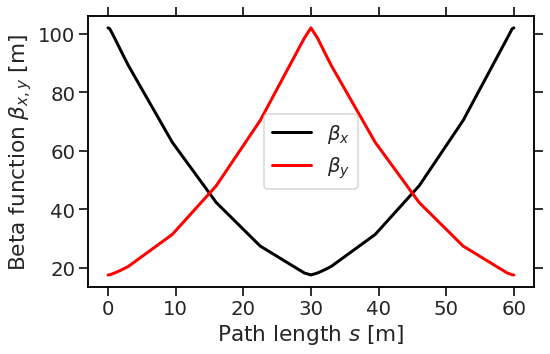

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='red')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m]')
plt.legend();

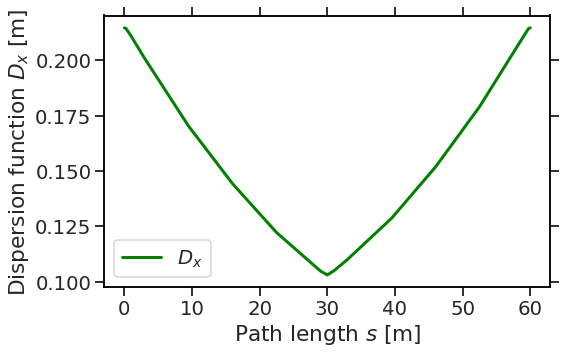

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['Dx'], label=r'$D_x$', color='green')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Dispersion function $D_x$ [m]')
plt.legend();

### <span style="color:blue;">i) Build a full ring with your basic cells.</span>

### <span style="color:blue;">How many cells do you need to close the ring? </span> 

Is the overall length below the required maximum length?

In [29]:
# Number of cells required
numberOfCells = round(np.pi*2/THB/4)
# Circumference of ring
circumference = numberOfCells*Lcell

numberOfCells, circumference

(1188, 71280)

Still 29 km to use

In [30]:
madx.input(f'''
    numberOfCells = {numberOfCells};
    L_JC_ring = numberOfCells*Lcell;
''')

True

Define a ring consisting of your FODO cells:

*Hint:* You can use while-loops in MAD-X sequence definitions.

In [31]:
madx.input('''
option, -info;
i = 0;
JC_ring : SEQUENCE, refer=centre, L=L_JC_ring; 
    while (i < numberOfCells) {
        JC_fodo_arc, at=(i + 0.5) * Lcell;
        i = i + 1;
    }
ENDSEQUENCE;
option, info;
''')

True

In [32]:
madx.use(sequence='JC_ring')

In [33]:
twiss=madx.twiss()

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
             71280                 -0    1.328326174e-05        274.3769567 

                q1                dq1            betxmax              dxmax 
       297.0118807   -2.715312932e-10        102.0232718        0.214621282 

             dxrms             xcomax             xcorms                 q2 
      0.1705339094                  0                  0        297.0118807 

               dq2            betymax              dymax              dyrms 
    1.78733933e-10        100.8148149                 -0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

### <span style="color:blue;">Do the tunes fit your expectation?</span>

In [34]:
total_phase_advance = numberOfCells * np.pi/2.0
total_tune = total_phase_advance / 2.0 / np.pi
total_tune

297.0

Yes, we get a reasonable fitting to our expectation!

(0.0, 500.0)

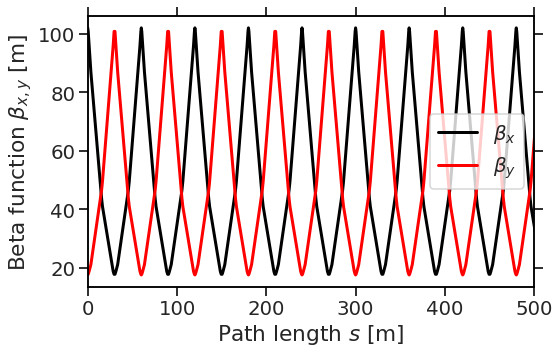

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='red')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m]')
plt.legend();
plt.xlim(0,500)

### <span style="color:blue;">Check if the ring is closed. </span>

If necessary adjust the bending angle accordingly.

In [36]:
survey = madx.survey()

In [37]:
survey['theta'][-1], np.pi*2

(-6.285419654366242, 6.283185307179586)

### <span style="color:blue;">j) Calculate the synchrotron radiation integrals using the 'chrom' option of the Twiss command.</span>

In [38]:
twiss=madx.twiss(chrom=True)

enter Twiss module
  
iteration:   1 error:   1.571359E-10 deltap:   1.000000E-06
orbit:   2.146212E-07  8.870497E-11  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
             71280                 -0    1.328326174e-05        274.3769567 

                q1                dq1            betxmax              dxmax 
       297.0118807   -1.421085472e-06        102.0232718        0.214621282 

             dxrms             xcomax             xcorms                 q2 
      0.1705339094                  0                  0        297.0118807 

               dq2            betymax              dymax              dyrms 
   0.0001323314791        100.8148149                 -0                  0 

            ycomax            

You can access the results of the twiss summary table like this:

In [39]:
twiss.summary.synch_5, twiss.summary.synch_2

(3.983063635e-11, 0.000692804788)

### <span style="color:blue;">Calculate equilibrium emittance and energy loss per turn using the synchrotron radiation integrals. </span>

Do you obtain the emittance you were designing for?

In [40]:
I_5 = twiss.summary.synch_5
I_2 = twiss.summary.synch_2
J_x = 1
C_q = 3.832e-13 # m
C_gamma = 8.8460e-5 # m / GeV**3
gamma_L = 175/0.000511

epsilon_x_SRI = C_q * gamma_L** 2 * I_5 / (J_x * I_2)
U0_SRI = C_gamma * ENERGY**4 * I_2 / (2 * np.pi) # C_gamma instead of C_q

epsilon_x_SRI, U0_SRI

(2.583843241286179e-09, 4.937907876909721)

In principle, we obtain twice the emmittance as we would want to. --> Need for suppress dispersion?

In principle, we obtain twice the emmittance as we would want to. --> Need for suppress dispersion

$\,$

$\,$

## 3. Dispersion suppressors and straight sections

### <span style="color:blue;">a) Design a dispersion suppressor section for both start ("DSL") and end ("DSR") of the arc sections of your storage ring and implement it in MAD-X. What scheme do you use and why? Why is it not possible to use the identical section on both sides of an arc? </span>

In [41]:
# Define quadrupole strengths of the dispersion suppressor
madx.input('''
    K1QFDS1 := K1QF;
    K1QDDS1 := K1QD;
    K1QFDS2 := K1QF;
    K1QDDS2 := K1QD;
''')

True

In [42]:
# Define elements for of the dispersion suppressor
madx.input('''
    MBDS : SBEND, L:=LB, ANGLE:=0.5*THB;

    MQFDS1 : quadrupole, L=LQ, K1:=K1QFDS1;
    halfMQFDS1: quadrupole, L=0.5*LQ, K1:=K1QFDS1;
    MQDDS1 : quadrupole, L=LQ, K1:=K1QDDS1;
    halfMQDDS1: quadrupole, L=0.5*LQ, K1:=K1QDDS1;
    MQFDS2 : quadrupole, L=LQ, K1:=K1QFDS2;
    halfMQFDS2: quadrupole, L=0.5*LQ, K1:=K1QFDS2;
    MQDDS2 : quadrupole, L=LQ, K1:=K1QDDS2;
    halfMQDDS2: quadrupole, L=0.5*LQ, K1:=K1QDDS2;
''')

True

Define individual sequences for your DSL and DSR.

In [43]:
madx.input('''
LDS = 2*Lcell;
JC_dsl : SEQUENCE, REFER=centre, L=LDS;
    bMQF1: halfMQFDS1, at= .25*LQ;
    bMSF1: MSF, at= .5 *LQ + .5*LS+1.0;
    bMBDS1: MBDS, at= .5 *LQ + 1.0*LS + .5*LB + 2.0;
    bMBDS2: MBDS, at= .5 *LQ + 1.0*LS + 1.5*LB + 3.0;
    bMQD1: MQDDS1, at=1.0 *LQ + 1.0*LS + 2.0*LB + 4.0;
    bMSD1: MSD, at=1.5 *LQ + 1.5*LS + 2.0*LB + 5.0;
    bMBDS3: MBDS, at=1.5 *LQ + 2.0*LS + 2.5*LB + 6.0;
    bMBDS4: MBDS, at=1.5 *LQ + 2.0*LS + 3.5*LB + 7.0;
    bMQF2: halfMQFDS2, at=1.75*LQ + 2.0*LS + 4.0*LB + 8.0; 
!
    bMQF1_1: halfMQFDS2, at= .25*LQ + Lcell;
    bMSF1_1: MSF, at= .5 *LQ + .5*LS+1.0 + Lcell;
    bMBDS1_1: MBDS, at= .5 *LQ + 1.0*LS + .5*LB + 2.0 + Lcell;
    bMBDS2_1: MBDS, at= .5 *LQ + 1.0*LS + 1.5*LB + 3.0 + Lcell;
    bMQD1_1: MQDDS2, at=1.0 *LQ + 1.0*LS + 2.0*LB + 4.0+ Lcell;
    bMSD1_1: MSD, at=1.5 *LQ + 1.5*LS + 2.0*LB + 5.0 + Lcell;
    bMBDS3_1: MBDS, at=1.5 *LQ + 2.0*LS + 2.5*LB + 6.0 + Lcell;
    bMBDS4_1: MBDS, at=1.5 *LQ + 2.0*LS + 3.5*LB + 7.0 + Lcell;
    bMQF2_1: halfMQFDS1, at=1.75*LQ + 2.0*LS + 4.0*LB + 8.0 + Lcell;
ENDSEQUENCE;
!
JC_dsr : SEQUENCE, REFER=centre, L=LDS;
    aMQF1: halfMQFDS2, at= .25*LQ;
    aMSF1: MSF, at= .5 *LQ + .5*LS+1.0;
    aMBDS1: MBDS, at= .5 *LQ + 1.0*LS + .5*LB + 2.0;
    aMBDS2: MBDS, at= .5 *LQ + 1.0*LS + 1.5*LB + 3.0;
    aMQD1: MQDDS2, at=1.0 *LQ + 1.0*LS + 2.0*LB + 4.0;
    aMSD1: MSD, at=1.5 *LQ + 1.5*LS + 2.0*LB + 5.0;
    aMBDS3: MBDS, at=1.5 *LQ + 2.0*LS + 2.5*LB + 6.0;
    aMBDS4: MBDS, at=1.5 *LQ + 2.0*LS + 3.5*LB + 7.0;
    aMQF2: halfMQFDS1, at=1.75*LQ + 2.0*LS + 4.0*LB + 8.0; 
!
    aMQF1_1: halfMQFDS1, at= .25*LQ + Lcell;
    aMSF1_1: MSF, at= .5 *LQ + .5*LS+1.0 + Lcell;
    aMBDS1_1: MBDS, at= .5 *LQ + 1.0*LS + .5*LB + 2.0 + Lcell;
    aMBDS2_1: MBDS, at= .5 *LQ + 1.0*LS + 1.5*LB + 3.0 + Lcell;
    aMQD1_1: MQDDS1, at=1.0 *LQ + 1.0*LS + 2.0*LB + 4.0+ Lcell;
    aMSD1_1: MSD, at=1.5 *LQ + 1.5*LS + 2.0*LB + 5.0 + Lcell;
    aMBDS3_1: MBDS, at=1.5 *LQ + 2.0*LS + 2.5*LB + 6.0 + Lcell;
    aMBDS4_1: MBDS, at=1.5 *LQ + 2.0*LS + 3.5*LB + 7.0 + Lcell;
    aMQF2_1: halfMQFDS2, at=1.75*LQ + 2.0*LS + 4.0*LB + 8.0 + Lcell;
ENDSEQUENCE;
''')

True

Define a small sequence to illustrate the features of the dispersion suppressor. Use following layout: `arc cell`...`arc cell` `disp.suppr. right` `marker` `disp.suppr. left` `arc cell`...`arc cell`

In [44]:
madx.input('''
mark_endds: marker;

match_DS : SEQUENCE, refer=centre, L = 8*Lcell;
JC_fodo_arc, at = 0.5*Lcell;
JC_fodo_arc, at = 1.5*Lcell;
JC_dsr, at = 3*Lcell;
mark_endds, at =4*Lcell;
JC_dsl, at = 5*Lcell;
JC_fodo_arc, at = 6.5*Lcell;
JC_fodo_arc, at = 7.5*Lcell;
ENDSEQUENCE;
''')

True

Save start values of periodic solutions as start values for non-periodic matching procedures:

We need to save the optics functions `betx`, `bety`, `alfx`, `alfy`, `dx`,and `dpx` as references for non-periodic Twiss calculations like for example the to illustrate how the dispersion suppressor works.

In [45]:
madx.use(sequence='JC_fodo_arc')

In [46]:
madx.command.savebeta(label='start.fodo.arc', place='#s')  # Comment '#s' marks the start of the sequence, '#e' the end

True

In [47]:
twiss_fodo_arc=madx.twiss()

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                60                 -0    1.328326174e-05        274.3769567 

                q1                dq1            betxmax              dxmax 
      0.2500100006   -2.285430089e-13        102.0232718        0.214621282 

             dxrms             xcomax             xcorms                 q2 
       0.170529498                  0                  0       0.2500100006 

               dq2            betymax              dymax              dyrms 
   1.504601152e-13        100.8148149                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

The optics functions at the beginning of your basic cell are now saved in MAD-X under the label `start.fodo.arc`. To get the beta function you can in MAD-X use: `value, start.fodo.arc->betx;` or you can save it in a variable: `foo=start.fodo.arc->betx;`

In [48]:
madx.command.show('start.fodo.arc')

command: beta0  module: control
parameter: betx   

True

double value:        102.0232718
parameter: alfx   double value:    1.003470945e-06
parameter: mux   double value:                  0
parameter: bety   double value:        17.64106301
parameter: alfy   double value:   -1.198585504e-16
parameter: muy   double value:                  0
parameter: x   double value:                  0
parameter: px   double value:                  0
parameter: y   double value:                  0
parameter: py   double value:                  0
parameter: t   double value:                  0
parameter: pt   double value:                  0
parameter: dx   double value:        0.214621282
parameter: dpx   double value:    8.870527265e-05
parameter: dy   double value:                  0
parameter: dpy   double value:                 -0
parameter: wx   double value:                  0
parameter: phix   double value:                  0
parameter: dmux   double value:                  0
parameter: wy   double value:                  0
parameter: phiy   double 

Alternatively, you can get the values from the python object `twiss_fodo_arc`, which contains the results of the twiss calculation above.

In [49]:
twiss_fodo_arc['betx'][0],twiss_fodo_arc['bety'][0],twiss_fodo_arc['alfx'][0],twiss_fodo_arc['alfy'][0],twiss_fodo_arc['dx'][0],twiss_fodo_arc['dpx'][0]

(102.02327182182907,
 17.641063014867772,
 1.0034709454121607e-06,
 -1.1985855040489322e-16,
 0.214621281972872,
 8.870527265224732e-05)

In [50]:
madx.use(sequence='match_DS')

In [51]:
madx.command.savebeta(label='supressor_limits', place='mark_endds')  # Comment '#s' marks the start of the sequence, '#e' the end

True

Perform a non-periodic Twiss calculation with the just saved starting values and have a look at the optics:

In [52]:
twiss=madx.twiss(betx=twiss_fodo_arc['betx'][0], 
                 bety=twiss_fodo_arc['bety'][0], 
                 alfx=twiss_fodo_arc['alfx'][0], 
                 alfy=twiss_fodo_arc['alfy'][0], 
                 dx=twiss_fodo_arc['dx'][0], 
                 dpx=twiss_fodo_arc['dpx'][0], centre=True)

enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               480                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       2.000073198                  0         102.024019       0.2146222234 

             dxrms             xcomax             xcorms                 q2 
      0.1426794406                  0                  0        2.000080005 

               dq2            betymax              dymax              dyrms 
                 0        102.0235481                  0                  0 

            ycomax             ycorms             deltap            synch_1 


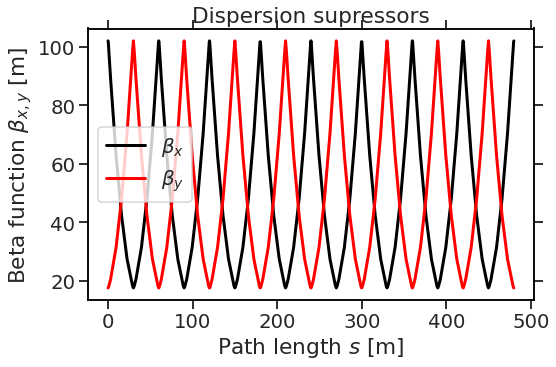

In [53]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='red')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m]')
plt.title('Dispersion supressors')
plt.legend();

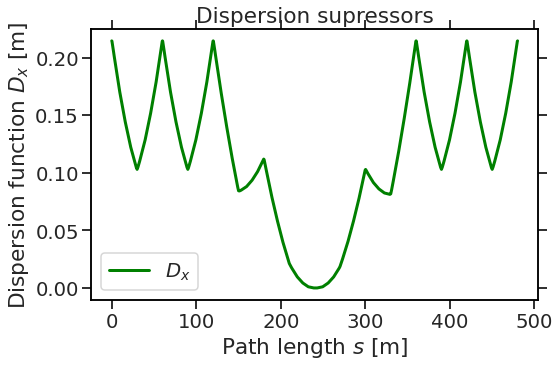

In [54]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['Dx'], label=r'$D_x$', color='green')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Dispersion function $D_x$ [m]')
plt.title('Dispersion supressors')
plt.legend();

Value of the dispersion function at the end of the dispersion suppressor (center of this sequence):

In [55]:
twiss['dx'][twiss['name'] == 'mark_endds:1'] # in m

array([2.26691172e-06])

In [56]:
supressor = madx.table.summ.dframe()

### <span style="color:blue;">b) Define a straight cell for the straight sections </span>

In [57]:
madx.input('''
   K1QFS := K1QF;
    K1QDS := K1QD;

    MQFS     :  quadrupole, L=LQ,    K1:=K1QFS;
    halfMQFS :  quadrupole, L=LQ*.5, K1:=K1QFS;
    MQDS     :  quadrupole, L=LQ,    K1:=K1QDS;

JC_fodo_ss : SEQUENCE, REFER=centre, L=Lcell;
    cMQFS1: halfMQFS, at= .25*LQ;
    !cMSF1: MSF, at= .5 *LQ + .5*LS+1.0;
    cMQDS1: MQDS, at=1.0 *LQ + 1.0*LS + 2.0*LB + 4.0;
    !cMSD1: MSD, at=1.5 *LQ + 1.5*LS + 2.0*LB + 5.0;
    cMQFS2: halfMQFS, at=1.75*LQ + 2.0*LS + 4.0*LB + 8.0;
ENDSEQUENCE;
''')

True

Calculate the optics of the straight cell. If necessary, re-match the optics.

In [58]:
madx.use(sequence='JC_fodo_ss')

In [59]:
madx.command.savebeta(label='start.straight.ss', place='#s')
straight_start = madx.table.summ.dframe()
madx.command.savebeta(label='end.straight.ss', place='#e')
straight_end = madx.table.summ.dframe()

In [60]:
twiss_suppr = twiss
twiss=madx.twiss(centre=True)

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                60                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.2500077318       -0.318318662        102.0237699                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.2500100006 

               dq2            betymax              dymax              dyrms 
     -0.3183209059        102.0235481                 -0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

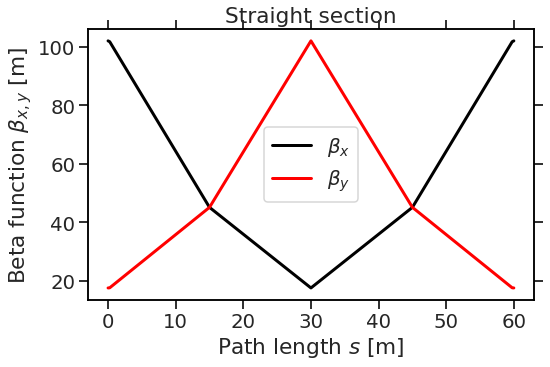

In [61]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='red')
plt.title('Straight section')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m]')
plt.legend();

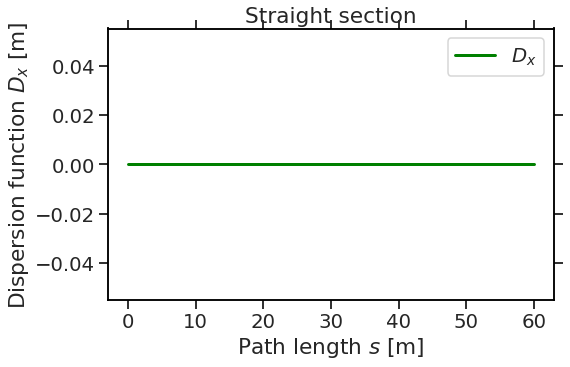

In [62]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['Dx'], label=r'$D_x$', color='green')
plt.xlabel('Path length $s$ [m]')
plt.title('Straight section')
plt.ylabel(r'Dispersion function $D_x$ [m]')
plt.legend();

### <span style="color:blue;">c) Define matching sections for the beginning ("MSL") and the end ("MSR") of your straight sections. Why do you need matching sections? How many parameters do you need to match? How many degrees of freedoms (=quadrupoles) do you need? </span>

Idea: Since the straight section is going to be installed in the middle of both dispersion supresors, we should check if the optical functions match at in the following places:
- End of the 1st dispersion supressor vs. Beginning of the straight section (Otherwise, define MSL)
- End of the straight section vs. Beginning of the 2nd dispersion supressor (Otherwise, define MSR)


For that, we can compare the twiss parameters obtained at "mark_endds" for the dispersion supressor with the twiss parameters from section b)

We have to match $\alpha_x$, $\alpha_y$, $\beta_x$, and $\beta_y$. Four parameters thus four quadrupoles.

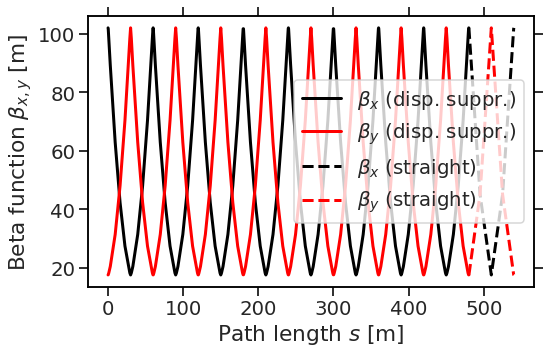

In [63]:
plt.figure(figsize=(8, 5))
plt.plot(twiss_suppr['s'], twiss_suppr['betx'], label=r'$\beta_x$ (disp. suppr.)', color='black')
plt.plot(twiss_suppr['s'], twiss_suppr['bety'], label=r'$\beta_y$ (disp. suppr.)', color='red')
shift = twiss_suppr['s'][-1]
plt.plot(twiss['s'] + shift, twiss['betx'], label=r'$\beta_x$ (straight)', color='black', ls='--')
plt.plot(twiss['s'] + shift, twiss['bety'], label=r'$\beta_y$ (straight)', color='red', ls='--')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m]')
plt.legend(); # comment this line out for better view

In [64]:
# Other option
#print('End of suppr -> straight line')
#print('[1] Rel. diff on betax: ', (twiss_suppr['betx'][-1] - twiss['betx'][0]) / twiss_suppr['betx'][-1])
#print('[1] Rel. diff on betay: ', (twiss_suppr['bety'][-1] - twiss['bety'][0]) / twiss_suppr['bety'][-1])
#print('[1] Rel. diff on alfx: ', (twiss_suppr['alfx'][-1] - twiss['alfx'][0]) / twiss_suppr['alfx'][-1])
#print('[1] Rel. diff on alfy: ', (twiss_suppr['alfy'][-1] - twiss['alfy'][0]) / twiss_suppr['alfy'][-1])#

#print('\nEnd of straight line -> suppr')
#print('[1] Rel. diff on betax: ', (twiss['betx'][0] - twiss_suppr['betx'][-1]) / twiss['betx'][0])
#print('[1] Rel. diff on betay: ', (twiss['bety'][0] - twiss_suppr['bety'][-1]) / twiss['bety'][0])
#print('[1] Rel. diff on alfx: ', (twiss['alfx'][0] - twiss_suppr['alfx'][-1]) / twiss['alfx'][0])
#print('[1] Rel. diff on alfy: ', (twiss['alfy'][0] - twiss_suppr['alfy'][-1]) / twiss['alfy'][0])

In [65]:
madx.input('''
    K1QFMS1 := K1QFS;
    K1QDMS1 := K1QDS;
    K1QFMS2 := K1QFS;
    K1QDMS2 := K1QDS;
    K1QFMS3 := K1QFS;
    K1QDMS3 := K1QDS;
    
    MQFMS1   :  quadrupole, L=LQ,    K1:=K1QFMS1;
    halfMQFMS1: quadrupole, L=0.5*LQ, K1:=K1QFMS1;
    MQDMS1   :  quadrupole, L=LQ,    K1:=K1QDMS1;
    MQFMS2   :  quadrupole, L=LQ,    K1:=K1QFMS2;
    halfMQFMS2: quadrupole, L=0.5*LQ, K1:=K1QFMS2;
    MQDMS2   :  quadrupole, L=LQ,    K1:=K1QDMS2;
    MQFMS3   :  quadrupole, L=LQ,    K1:=K1QFMS3;
    halfMQFMS3: quadrupole, L=0.5*LQ, K1:=K1QFMS3;
    MQDMS3   :  quadrupole, L=LQ,    K1:=K1QDMS3;
''')

True

*Comment:* If you use quadrupoles with half the length be careful about the type of quadrupole at the beginning and at the end of the matching section. They might belong to a regular cell or the dispersion suppressor.

In [66]:
madx.input('''
LMS=3*Lcell; ! length of the matching section

JC_msl : SEQUENCE, REFER=centre, L=LMS;
    eMQFMS1: halfMQFMS1, at= .25*LQ;
    eMQDMS1: MQDMS1,     at=1.0 *LQ + 1.0*LS + 2.0*LB + 4.0;
    eMQFMS2: halfMQFMS2, at=1.75*LQ + 2.0*LS + 4.0*LB + 8.0; 
!
    eMQFMS3: halfMQFMS2, at=.25 *LQ + Lcell;
    eMQDMS2: MQDMS2,     at=1.0 *LQ + 1.0*LS + 2.0*LB + 4.0 + Lcell;
    eMQFMS4: halfMQFMS3, at=1.75*LQ + 2.0*LS + 4.0*LB + 8.0 + Lcell;
!
    eMQFMS5: halfMQFMS3, at=.25 *LQ + 2*Lcell;
    eMQDMS3: MQDMS3,     at=1.0 *LQ + 1.0*LS + 2.0*LB + 4.0 + 2*Lcell;
    eMQFMS6: halfMQFMS1, at=1.75*LQ + 2.0*LS + 4.0*LB + 8.0 + 2*Lcell;
ENDSEQUENCE;

JC_msr : SEQUENCE, REFER=centre, L=LMS;
    eMQFMS7: halfMQFMS3, at= .25*LQ;
    eMQDMS4: MQDMS3,     at=1.0 *LQ + 1.0*LS + 2.0*LB + 4.0;
    eMQFMS8: halfMQFMS2, at=1.75*LQ + 2.0*LS + 4.0*LB + 8.0; 
!
    eMQFMS9: halfMQFMS2, at=.25 *LQ + Lcell;
    eMQDMS5: MQDMS2,     at=1.0 *LQ + 1.0*LS + 2.0*LB + 4.0 + Lcell;
    eMQFMS10:halfMQFMS1, at=1.75*LQ + 2.0*LS + 4.0*LB + 8.0 + Lcell;
!
    eMQFMS11:halfMQFMS1, at=.25 *LQ + 2*Lcell;
    eMQDMS6: MQDMS1,     at=1.0 *LQ + 1.0*LS + 2.0*LB + 4.0 + 2*Lcell;
    eMQFMS12:halfMQFMS3, at=1.75*LQ + 2.0*LS + 4.0*LB + 8.0 + 2*Lcell;
ENDSEQUENCE;
''')

True

Define a small symmetric sequence to match the optics at the transition from the periodic solution in the arc to the one in the straight section. Use following structure: `arc cell` `DSR` `MSL` `straight cell` ... `straight cell` `MSR` `DSL` `arc cell`

In [67]:
madx.input('''
mark_fodos_ss: marker;

match_MS : sequence, refer=centre, L = 4*Lcell + 2*LDS + 2*LMS;
    JC_fodo_arc,   at = 0.5*Lcell;
    JC_dsr,        at =     Lcell + 0.5*LDS;
    mark_endds,    at =     Lcell +     LDS;           ! Marker at the end of the dispersion suppressor
    JC_msl,        at =     Lcell +     LDS +  .5*LMS;
    mark_fodos_ss, at =     Lcell +     LDS +     LMS; ! Marker at the end of the matching section, beginning of straight FODO cell
    JC_fodo_ss,    at = 1.5*Lcell +     LDS +     LMS;
    JC_fodo_ss,    at = 2.5*Lcell +     LDS +     LMS;
    JC_msr,        at = 3.0*Lcell +     LDS + 1.5*LMS;
    JC_dsl,        at = 3.0*Lcell + 1.5*LDS + 2.0*LMS;
    JC_fodo_arc,   at = 3.5*Lcell + 2.0*LDS + 2.0*LMS;
ENDSEQUENCE;
''')

True

In [68]:
madx.use(sequence='match_MS')

Start the optics calculation with values at the begining of the arc fodo cell

In [69]:
twiss_fodo_arc['betx'][0], twiss_fodo_arc['bety'][0], twiss_fodo_arc['alfx'][0], twiss_fodo_arc['alfy'][0],twiss_fodo_arc['dx'][0], twiss_fodo_arc['dpx'][0]

(102.02327182182907,
 17.641063014867772,
 1.0034709454121607e-06,
 -1.1985855040489322e-16,
 0.214621281972872,
 8.870527265224732e-05)

In [70]:
twiss = madx.twiss(betx=twiss_fodo_arc['betx'][0], 
                   bety=twiss_fodo_arc['bety'][0], 
                   alfx=twiss_fodo_arc['alfx'][0], 
                   alfy=twiss_fodo_arc['alfy'][0],
                   dx=twiss_fodo_arc['dx'][0], 
                   dpx=twiss_fodo_arc['dpx'][0], centre=True)

enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               840                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       3.500115051                  0        102.0242681        0.214622219 

             dxrms             xcomax             xcorms                 q2 
      0.1102459538                  0                  0        3.500140009 

               dq2            betymax              dymax              dyrms 
                 0        102.0235481                  0                  0 

            ycomax             ycorms             deltap            synch_1 


In [71]:
madx.input('''select,flag=twiss,column=name,s,betx,bety,dx,dy''')
# madx.twiss();
twiss=madx.twiss(centre=True,file='bastian1.out') 

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               840                 -0    2.846397386e-06        592.7236198 

                q1                dq1            betxmax              dxmax 
       3.500115051        -3.18318505        102.0238925       0.2146217545 

             dxrms             xcomax             xcorms                 q2 
      0.1102458088                  0                  0        3.500140009 

               dq2            betymax              dymax              dyrms 
      -3.183206921        102.0235481                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

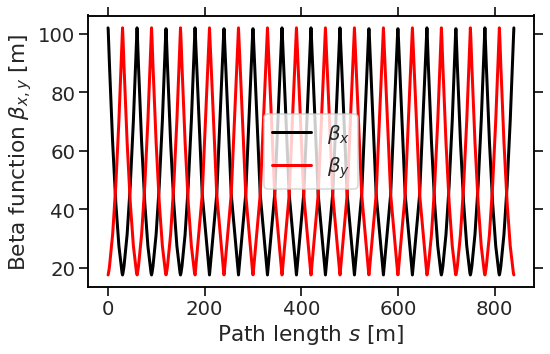

In [72]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='red')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m]')
plt.legend();

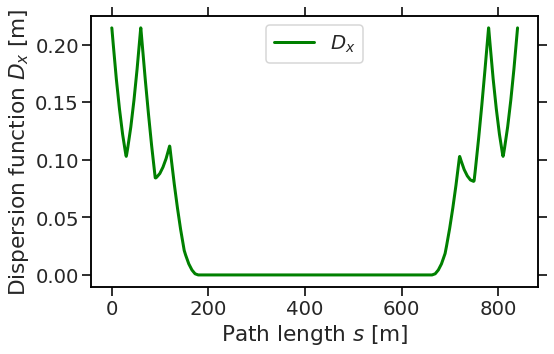

In [73]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['Dx'], label=r'$D_x$', color='green')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Dispersion function $D_x$ [m]')
plt.legend();

Match the optics. Where do you have to fulfill what constraints? Do you need to install markers in your sequence to retrieve that information?

In [74]:
madx.input('''
match, sequence= match_MS, beta0=start.fodo.arc;
!    constraint, range=mark_endds,    betx=supressor_limits->betx, bety=17.64, dx=0, dpx=0, alfx=0, alfy=0;
    constraint, range=mark_fodos_ss, betx=start.straight.ss->betx , bety=17.64,              alfx=0, alfy=0;
    constraint, range=mark_endds,    dx=0, dpx=0;
    constraint, range=#e, betx=start.fodo.arc->betx, alfx=start.fodo.arc->alfx;
    vary, name=k1qfds1, step=1.0E-10;
    vary, name=k1qdds1, step=1.0E-10;
    vary, name=k1qfds2, step=1.0E-10;
    vary, name=k1qdds2, step=1.0E-10;
    vary, name=k1qfms1, step=1.0E-10;
    vary, name=k1qdms1, step=1.0E-10;
    vary, name=k1qfms2, step=1.0E-10;
    vary, name=k1qdms2, step=1.0E-10;
    vary, name=k1qdms3, step=1.0E-10;
    vary, name=k1qfms3, step=1.0E-10;
JACOBIAN, CALLS=20, TOLERANCE=1e-10;
endmatch;
''')

START MATCHING

number of sequences: 1
sequence name: match_ms
number of beta0s: 1
BETA0 name: start.fodo.arc
number of variables:    10
user given constraints: 2
total constraints:      8

START JACOBIAN:

 JACOBIAN Strategy =           3
Initial Penalty Function =   0.1378890640681286E-05


 Solve system with            8 con,          10 var
 Rank             8   Condition number    18664.204814012817     
 Step length    8.8933193618587973E-004
call:     2 Dx =   0.88933194E-03  Penalty function =  0.1333345403573494E-05
 Solve system with            8 con,          10 var
 Rank             8   Condition number    5609.3799479968829     
 Step length    1.2834007166276683E-003
call:     3 Dx =   0.12834007E-02  Penalty function =  0.9952518079129891E-06
 Solve system with            8 con,          10 var
 Rank             8   Condition number    4342.9854417186307     
 Step length    4.3114372743374588E-004
call:     4 Dx =   0.43114373E-03  Penalty function =  0.1811460311552267

True

In [75]:
twiss = madx.twiss(betx=twiss_fodo_arc['betx'][0], 
                   bety=twiss_fodo_arc['bety'][0], 
                   alfx=twiss_fodo_arc['alfx'][0], 
                   alfy=twiss_fodo_arc['alfy'][0],
                   dx=twiss_fodo_arc['dx'][0], 
                   dpx=twiss_fodo_arc['dpx'][0], centre=True)

enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               840                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       3.502368669                  0        102.0811704       0.2146225749 

             dxrms             xcomax             xcorms                 q2 
      0.1102482628                  0                  0        3.501043556 

               dq2            betymax              dymax              dyrms 
                 0        102.0730122                  0                  0 

            ycomax             ycorms             deltap            synch_1 


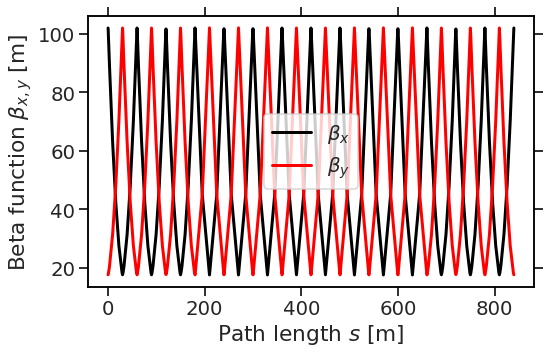

In [76]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='red')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m]')
plt.legend();

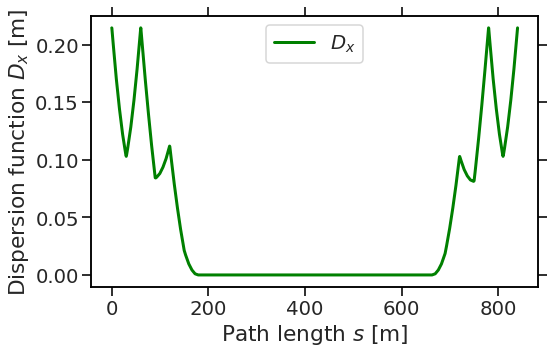

In [77]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['Dx'], label=r'$D_x$', color='green')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Dispersion function $D_x$ [m]')
plt.legend();

Confirm the matching result with a periodic Twiss calculation.

In [78]:
twiss=madx.twiss()

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               840                 -0    2.846474165e-06        592.7156259 

                q1                dq1            betxmax              dxmax 
        3.50236867       -3.187264979        102.0812311        0.214622125 

             dxrms             xcomax             xcorms                 q2 
      0.1102485069                  0                  0        3.501043543 

               dq2            betymax              dymax              dyrms 
       -3.18578411        100.8642638                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

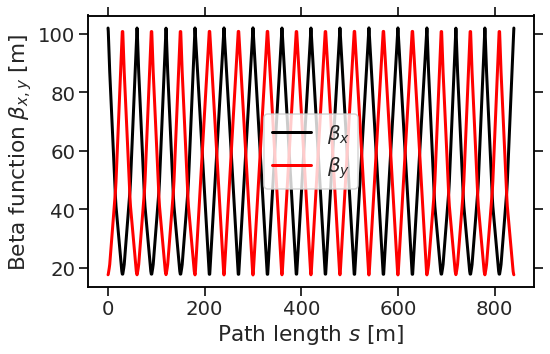

In [79]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='red')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m]')
plt.legend();

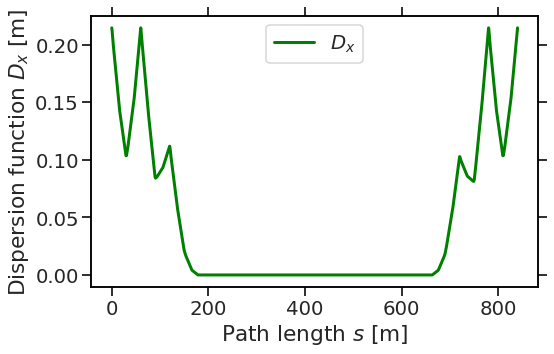

In [80]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['Dx'], label=r'$D_x$', color='green')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Dispersion function $D_x$ [m]')
plt.legend();

### <span style="color:blue;">d) Include straight sections at four places in your ring</span>

How do you distribute the straight sections?

In [81]:
numberOfArcCells = int(numberOfCells/4)
numberOfStraightCells = int(np.ceil(1100. / Lcell))
print(numberOfStraightCells)

19


In [82]:
madx.input('''
numberOfArcCells = numberOfCells/4;
numberOfStraightCells = 19;
''')

True

Define sequences for your arcs, straight sections and the full ring. As this ring becomes very long, also define a sequence for one quarter of the ring to speed up matching routines (one straight section and one arc).

We use the following structure to define the arcs: <br />`dispersion suppressor left` `arc cell`...`arc cell` `dispersion suppressor right`

We use the following structure to define the straight sections: <br />`matching section left` `straight cell`...`straight cell` `matching section right`

In [83]:
madx.input('''
Larc=numberOfArcCells*Lcell+2*LDS;

option, -info;
i = 0;
JC_arc : SEQUENCE, refer=centre, L=Larc; 
    JC_dsl, at = LDS / 2;
    while (i < numberOfArcCells) {
        JC_fodo_arc, at=LDS + (i + 0.5) * Lcell;
        i = i + 1;
    }
    JC_dsr, at=numberOfArcCells * Lcell + 1.5 * LDS;
ENDSEQUENCE;
option, info;

LSS=numberOfStraightCells*Lcell+2*LMS;

option, -info;
j=0;
JC_ss : SEQUENCE, refer=centre, L=LSS; 
    JC_msl, at = LMS/2;
    while (j<numberOfStraightCells) {
        JC_fodo_ss,  at = LMS + (j+0.5)*Lcell;
        j=j+1;
    }
    JC_msr, at =numberOfStraightCells*Lcell+1.5*LMS;
ENDSEQUENCE;
option, info;


JC_quarter : sequence, refer=centre, L=Larc+Lss;
    JC_ss, at=0.5*Lss;
    JC_arc, at = Lss+0.5*Larc;
ENDSEQUENCE;

LJC=4*(Larc+Lss);

JC : SEQUENCE, refer=centre, L=LJC;
    JC_arc, at = 0.5*Larc;
    JC_ss, at = 1.0*Larc+0.5*Lss;
    JC_arc, at = 1.5*Larc+Lss;
    JC_ss, at = 2.0*Larc+1.5*Lss;
    JC_arc, at = 2.5*Larc+2*Lss;
    JC_ss, at = 3.0*Larc+2.5*Lss;
    JC_arc, at = 3.5*Larc+3*LSS;
    JC_ss, at = 4.0*Larc+3.5*Lss;
ENDSEQUENCE;
''')

True

In [84]:
madx.use(sequence='JC')

In [85]:
twiss = madx.twiss()

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
             78240                 -0    1.214237071e-05        286.9777696 

                q1                dq1            betxmax              dxmax 
       326.0218011       -34.39472543        102.0811876       0.2146221321 

             dxrms             xcomax             xcorms                 q2 
      0.1673574229                  0                  0        326.0166549 

               dq2            betymax              dymax              dyrms 
      -34.38989035        101.0958556                 -0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

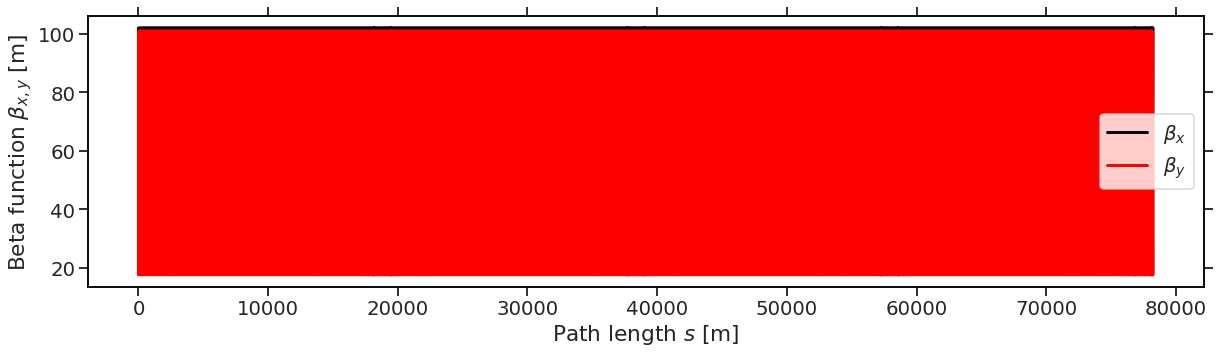

In [86]:
plt.figure(figsize=(20, 5))
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='red')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m]')
plt.legend();
# plt.xlim(15000,23000)

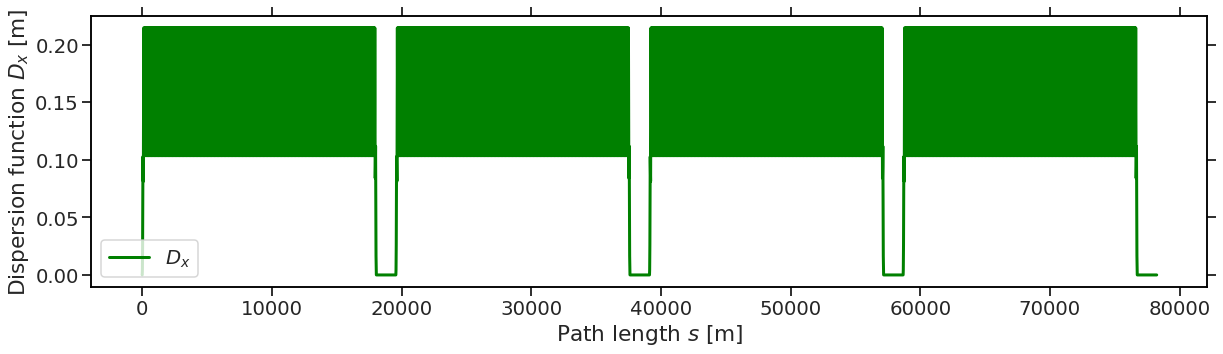

In [87]:
plt.figure(figsize=(20, 5))
plt.plot(twiss['s'], twiss['Dx'], label=r'$D_x$', color='green')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Dispersion function $D_x$ [m]')
plt.legend();
# plt.xlim(15000,23000)

### <span style="color:blue;">e) Observe tunes and chromaticities. Do they match your expectation? Re-match tunes and chromaticities.</span>

First, the tunes need to be matched to avoid hitting any resonances. As this storage ring is very long, the quadrupole strengths of the arc cells could be used to do the adjustment. If the phase advance of those cells is critical and should not be touched the quadrupoles of the straight cells can be used. In order to avoid distortions of the optics, an advanced matching procedure is presented in this context. <br />
We want to match following tunes:

In [88]:
tuneToBeX = twiss['s'][-1]/Lcell*mu_x/2/np.pi + 0.59
tuneToBeY = twiss['s'][-1]/Lcell*mu_y/2/np.pi + 0.55 # avoid resonances

madx.input(f'''
tuneToBeX = {tuneToBeX};
tuneToBeY = {tuneToBeY};
''')

True

In [89]:
twiss['s'][-1]/Lcell*mu_x/2/np.pi

326.0

---
#### <span style="color:#af0000;">GURU mode switched on!</span>

Lean back, enjoy the show and learn:

For the matching we only use one quarter of the ring to speed up the process:

In [90]:
madx.use(sequence='JC_quarter')

A set of markers is installed to mark the beginning of two straight cells and the beginning of the arc fodo cells. Take notice of the comments to place your markers correctly.

In [91]:
madx.input('''
SEQEDIT, sequence=JC_quarter;
    flatten;
ENDEDIT;
SEQEDIT, sequence=JC_quarter;
    install, element=marker_s1, class=marker, at= 3*Lcell; ! start of first straight fodo cell
    install, element=marker_s2, class=marker, at= 4*Lcell; ! end of first straight fodo cell
    install, element=marker_startfodo,   class=marker, at= LSS+LDS; ! start of first arc fodo cell
    install, element=marker_startfodo2,    class=marker, at= LSS+LDS; ! end of first arc fodo cell
ENDEDIT;
SEQEDIT, sequence=JC_quarter;
    flatten;
ENDEDIT;
''')

++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
++++++ info: seqedit - number of elements installed:  4
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

The sequence is rearranged such that it starts with the regular arc cells and ends at the end of the dispersion suppressor AFTER the straight section. In other words, we start and end at the beginning of a regular arc cell, where we know the periodic solution of the optics functions.

In [92]:
madx.input('''
SEQEDIT, sequence=JC_quarter;
    cycle, start=marker_startfodo;
ENDEDIT;
SEQEDIT, sequence=JC_quarter;
    flatten;
ENDEDIT;
''')

++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

In [93]:
madx.use(sequence='JC_quarter')

In [94]:
madx.command.savebeta(label='start_JC', place='#S')

True

In [95]:
twiss = madx.twiss()

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
             19560                 -0    1.214237071e-05        286.9777696 

                q1                dq1            betxmax              dxmax 
       81.50545028       -8.598681358        102.0811876       0.2146221321 

             dxrms             xcomax             xcorms                 q2 
      0.1673351806                  0                  0        81.50416373 

               dq2            betymax              dymax              dyrms 
      -8.597472587        101.0958556                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

In [96]:
twiss['betx'][0], twiss['alfx'][0], twiss['dx'][0]

(102.02325787079134, 1.674299194669027e-06, 0.21462043174067252)

Validate the start values with a non-periodic Twiss calculation and observe the optics:

In [97]:
madx.twiss(beta0='start_JC');

enter Twiss module
 Found 6 initial orbit vector values from twiss command. 
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
             19560                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       81.50545028                  0        102.0811876       0.2146221321 

             dxrms             xcomax             xcorms                 q2 
      0.1673351806                  0                  0        81.50416373 

               dq2            betymax              dymax              dyrms 
                 0        101.0958556                  0                  0 

            ycomax 

(15000.0, 20000.0)

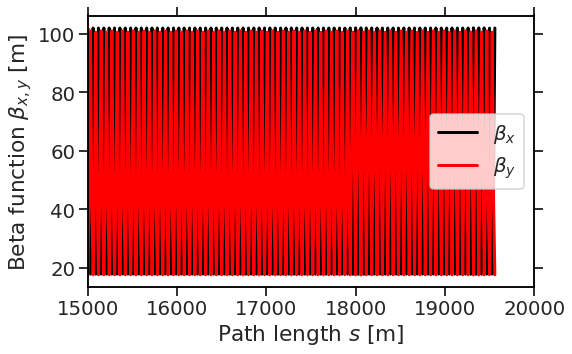

In [98]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='red')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m]')
plt.legend();
plt.xlim(15000,20000)

(15000.0, 20000.0)

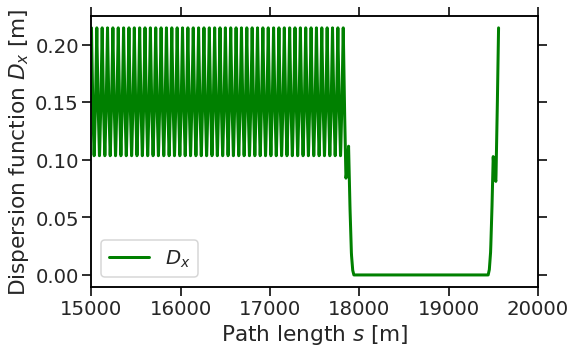

In [99]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['Dx'], label=r'$D_x$', color='green')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Dispersion function $D_x$ [m]')
plt.legend();
plt.xlim(15000,20000)

This matching command uses expressions to tailor the constraints. Expressions allow to access values of the Twiss calculations performed during the matching run. Besides the tunes, the 3rd and 4th constraint require the same values of the beta function at the beginning and at the end of one straight cell to obtain a periodic solution in the straight section. The following constraints target the end of the sequence, where the start values need to be restored in order to obtain an overall periodic solution.<br>
Because of the large number of constraints and variables, the matching needs to be done in two steps as indicated in the MAD-X code:

In [100]:
madx.input('''
match,use_macro;
    vary, name=K1QDDS1, step=1.0E-8;
    vary, name=K1QDDS2, step=1.0E-8;
    vary, name=K1QFDS1, step=1.0E-8;
    vary, name=K1QFDS2, step=1.0E-8;
!
    vary, name=k1qfs,   step=1.0E-8;
    vary, name=k1qds,   step=1.0E-8;
!
    vary, name=K1QDMS1, step=1.0E-8;
    vary, name=K1QDMS2, step=1.0E-8;
    vary, name=K1QDMS3, step=1.0E-8;
    vary, name=K1QFMS1, step=1.0E-8;
    vary, name=K1QFMS2, step=1.0E-8;
!
calc_twiss : macro= { USE,sequence= JC_quarter; TWISS, beta0=start_JC; };
!
    constraint, weight=10, expr=table(summ,q1)=0.25*tuneToBeX;
    constraint, weight=10, expr=table(summ,q2)=0.25*tuneToBeY;
!
    constraint, weight= 1, expr=table(twiss,marker_s2,betx)-table(twiss,marker_s1,betx)=0;
    constraint, weight= 1, expr=table(twiss,marker_s2,bety)-table(twiss,marker_s1,bety)=0;
!
    constraint, weight=10, expr=table(twiss,marker_startfodo2,betx)=start_JC->betx;
    constraint, weight=10, expr=table(twiss,marker_startfodo2,bety)=start_JC->bety;
!
    jacobian, calls=20, tolerance=1.0E-11, bisec=3;
endmatch;
''')

number of variables:    11
user given constraints: 0
total constraints:      6

START JACOBIAN:

 JACOBIAN Strategy =           3
Initial Penalty Function =   0.3795668394956775E+01


 Solve system with            6 con,          11 var
 Rank             6   Condition number    6359.6765808242262     
 Step length    2.1758459285161985E-002
 Bisec iteration            3
call:     2 Dx =   0.22091093E-01  Penalty function =  0.5916909609194979E+01
 Solve system with            6 con,          11 var
 Rank             6   Condition number    3401.7087457654134     
 Step length    1.3850553473433194E-002
 Bisec iteration            3
call:     3 Dx =   0.13948426E-01  Penalty function =  0.2369506799092241E+01
 Solve system with            6 con,          11 var
 Rank             6   Condition number    2309.5380704025251     
 Step length    9.1652031436432156E-003
 Bisec iteration            2
call:     4 Dx =   0.91982248E-02  Penalty function =  0.1354690729842438E+01
 Solve system w

True


MATCH SUMMARY

--------------------------------------------------------------------
macro: calc_twiss          
  constraint: table(summ,q1)=0.25*tunetobex           
  values:     +8.16475e+01=+8.16475e+01
  weight:     +1.00000e+01
  penalty:    +9.94760e-12

  constraint: table(summ,q2)=0.25*tunetobey           
  values:     +8.16375e+01=+8.16375e+01
  weight:     +1.00000e+01
  penalty:    -7.53175e-12

  constraint: table(twiss,marker_s2,betx)-table(twiss,marker_s1,betx)=0
  values:     +1.27613e-10=+0.00000e+00
  weight:     +1.00000e+00
  penalty:    +1.27613e-10

  constraint: table(twiss,marker_s2,bety)-table(twiss,marker_s1,bety)=0
  values:     -5.94227e-11=+0.00000e+00
  weight:     +1.00000e+00
  penalty:    -5.94227e-11

  constraint: table(twiss,marker_startfodo2,betx)=start_jc->betx
  values:     +1.02023e+02=+1.02023e+02
  weight:     +1.00000e+01
  penalty:    -1.01127e-08

  constraint: table(twiss,marker_startfodo2,bety)=start_jc->bety
  values:     +1.76405e+01=+

In [101]:
madx.twiss(betx=twiss_fodo_arc['betx'][0], 
                   bety=twiss_fodo_arc['bety'][0], 
                   alfx=twiss_fodo_arc['alfx'][0], 
                   alfy=twiss_fodo_arc['alfy'][0],
                   dx=twiss_fodo_arc['dx'][0], 
                   dpx=twiss_fodo_arc['dpx'][0], centre=True);

enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
             19560                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       81.64749992                  0        103.0986506        0.221021716 

             dxrms             xcomax             xcorms                 q2 
      0.1673523731                  0                  0        81.63770989 

               dq2            betymax              dymax              dyrms 
                 0         103.164938                  0                  0 

            ycomax             ycorms             deltap            synch_1 


(15000.0, 20000.0)

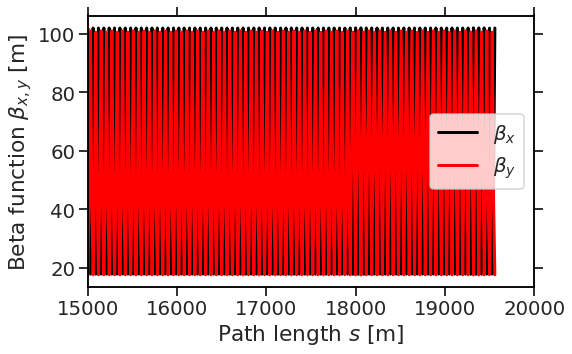

In [102]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='red')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m]')
plt.legend();
plt.xlim(15000,20000)

In [103]:
madx.input('''
match,use_macro;
    vary, name=K1QDDS1, step=1.0E-8;
    vary, name=K1QDDS2, step=1.0E-8;
    vary, name=K1QFDS1, step=1.0E-8;
    vary, name=K1QFDS2, step=1.0E-8;
!
    vary, name=k1qfs,   step=1.0E-8;
    vary, name=k1qds,   step=1.0E-8;
!
    vary, name=K1QDMS1, step=1.0E-8;
    vary, name=K1QDMS2, step=1.0E-8;
    vary, name=K1QDMS3, step=1.0E-8;
    vary, name=K1QFMS1, step=1.0E-8;
    vary, name=K1QFMS2, step=1.0E-8;
!
calc_twiss : macro= { USE,sequence= JC_quarter; TWISS, beta0=start_JC; };
!
    constraint, weight=10, expr=table(summ,q1)=0.25*tuneToBeX;
    constraint, weight=10, expr=table(summ,q2)=0.25*tuneToBeY;
!
    constraint, weight= 1, expr=table(twiss,marker_s2,betx)-table(twiss,marker_s1,betx)=0;
    constraint, weight= 1, expr=table(twiss,marker_s2,bety)-table(twiss,marker_s1,bety)=0;
!
    constraint, weight=10, expr=table(twiss,marker_startfodo2,betx)=start_JC->betx;
    constraint, weight=10, expr=table(twiss,marker_startfodo2,bety)=start_JC->bety;
!
    constraint, weight=10, expr=table(twiss,marker_startfodo2,alfx)=start_JC->alfx;
    constraint, weight=10, expr=table(twiss,marker_startfodo2,alfy)=start_JC->alfy;
    constraint, weight=10, expr=table(twiss,marker_startfodo2,dx)=start_JC->dx;
    constraint, weight=10, expr=table(twiss,marker_startfodo2,dy)=start_JC->dy;
    constraint, weight=10, expr=table(twiss,marker_startfodo2,dpx)=start_JC->dpx;
    constraint, weight=10, expr=table(twiss,marker_startfodo2,dpy)=start_JC->dpy;
!
    jacobian, calls=20, tolerance=1.0E-11, bisec=3;
endmatch;
''')

++++++ warning: macro redefined: calc_twiss
number of variables:    11
user given constraints: 0
total constraints:      12

START JACOBIAN:

 JACOBIAN Strategy =           3
Initial Penalty Function =   0.4714250203288974E-01


 Solve system with           10 con,          11 var
 Rank            10   Condition number    757604.64654612239     
 Step length    1.9224125432772972E-002
 Bisec iteration            2
call:     2 Dx =   0.19146379E-01  Penalty function =  0.3248614922642291E-01
 Solve system with           10 con,          11 var
 Rank            10   Condition number    1178388.7115468055     
 Step length    1.9976211383136884E-002
 Bisec iteration            2
call:     3 Dx =   0.19867593E-01  Penalty function =  0.1871088140653942E-01
 Solve system with           10 con,          11 var
 Rank            10   Condition number    1669094.5655127349     
 Step length    1.9779085331477899E-002
 Bisec iteration            3
call:     4 Dx =   0.19668940E-01  Penalty funct

True

1.76405e+01
  weight:     +1.00000e+01
  penalty:    -4.70076e-02

  constraint: table(twiss,marker_startfodo2,alfx)=start_jc->alfx
  values:     -1.14566e-02=+1.67430e-06
  weight:     +1.00000e+01
  penalty:    -1.14583e-01

  constraint: table(twiss,marker_startfodo2,alfy)=start_jc->alfy
  values:     +9.05803e-04=-2.30694e-03
  weight:     +1.00000e+01
  penalty:    +3.21274e-02

  constraint: table(twiss,marker_startfodo2,dx)=start_jc->dx
  values:     +2.18212e-01=+2.14620e-01
  weight:     +1.00000e+01
  penalty:    +3.59172e-02

  constraint: table(twiss,marker_startfodo2,dy)=start_jc->dy
  values:     +0.00000e+00=+0.00000e+00
  weight:     +1.00000e+01
  penalty:    +0.00000e+00

  constraint: table(twiss,marker_startfodo2,dpx)=start_jc->dpx
  values:     +7.39206e-05=+8.87115e-05
  weight:     +1.00000e+01
  penalty:    -1.47909e-04

  constraint: table(twiss,marker_startfodo2,dpy)=start_jc->dpy
  values:     +0.00000e+00=+0.00000e+00
  weight:     +1.00000e+01
  penalty:   

In [104]:
twiss = madx.twiss();
# madx.twiss(beta0='start_JC');

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
             19560                 -0    1.214278313e-05        286.9728962 

                q1                dq1            betxmax              dxmax 
       81.64661357       -8.887876046        103.9572413       0.2167995757 

             dxrms             xcomax             xcorms                 q2 
      0.1673474485                  0                  0        81.63776238 

               dq2            betymax              dymax              dyrms 
      -8.877525324        102.0162631                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

In [105]:
madx.command.value('0.25*tuneToBeX, 0.25*tuneToBeY')

0.25*tunetobex     =            81.6475 ;
0.25*tunetobey     =            81.6375 ;


True

(15000.0, 20000.0)

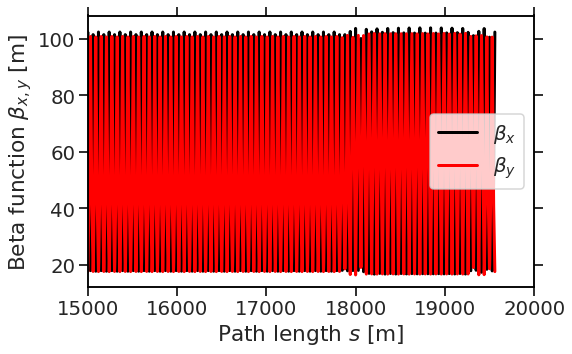

In [106]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='red')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m]')
plt.legend();
plt.xlim(15000,20000)

(15000.0, 20000.0)

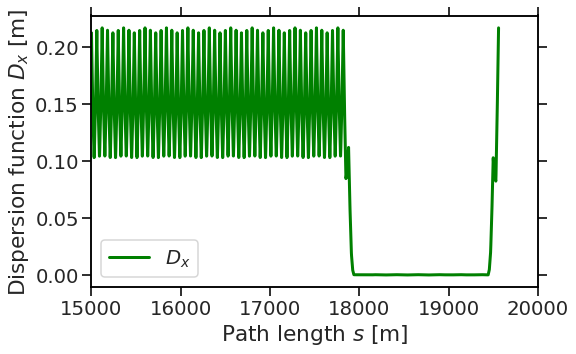

In [107]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['Dx'], label=r'$D_x$', color='green')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Dispersion function $D_x$ [m]')
plt.legend();
plt.xlim(15000,20000)

### <span style="color:#af0000;">GURU mode off! </span>

Returning to interactive mode! :-)

---

Now, reload the full storage ring and calculate tunes and chromaticity again.

In [108]:
madx.use(sequence='JC')

In [109]:
twiss = madx.twiss()

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
             78240                 -0    1.214278313e-05        286.9728962 

                q1                dq1            betxmax              dxmax 
       326.5864543       -35.55150419        103.9572413       0.2167995757 

             dxrms             xcomax             xcorms                 q2 
      0.1673682728                  0                  0        326.5510495 

               dq2            betymax              dymax              dyrms 
       -35.5101013        102.0162631                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

As a next step, we need to match the chromaticity again.

First, switch off the sextupoles and calculate the natural chromaticity of your storage ring. Can you confirm the relation $\mathcal{O}(\xi)\approx - Q$?

In [110]:
madx.input('''
    k2sf=0;
    k2sd=0;
''')

++++++ info: k2sf redefined


True

++++++ info: k2sd redefined


In [111]:
madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
             78240                 -0    1.214278313e-05        286.9728962 

                q1                dq1            betxmax              dxmax 
       326.5864543       -416.2517087        103.9572413       0.2167995757 

             dxrms             xcomax             xcorms                 q2 
      0.1673682728                  0                  0        326.5510495 

               dq2            betymax              dymax              dyrms 
      -416.2227262        102.0162631                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

Second, rematch the chromaticities. What value do you choose and why? (Think about instabilities and collective effects.)

Head tail instability above transition (high gamma). Chromaticity with negative values lead to this kind of instability. Since it is an electron ring, we are above transition for these energies

In [112]:
madx.input('''
match, sequence = JC;
    global, dq1 = 1.0; !uffff, just guessed here
    global, dq2 = 1.0; !uffff, just guessed here
    vary, name=k2sf,  step=1.0E-10 ;  
    vary, name=k2sd,  step=1.0E-10 ;
    jacobian,calls=20,tolerance=1.e-15,bisec=3;
endmatch;
''')

START MATCHING

number of sequences: 1
sequence name: jc
number of variables:    2
user given constraints: 1
total constraints:      2

START JACOBIAN:

 JACOBIAN Strategy =           3
Initial Penalty Function =   0.3481737916469226E+06


 Solve system with            2 con,           2 var
 Rank             2   Condition number    2.2007498904214886     
 Step length    1.0000000000000000     
call:     2 Dx =   0.10000000E+01  Penalty function =  0.1538605157449916E-14
 Solve system with            2 con,           2 var
 Rank             2   Condition number    2.2007498904474065     
 Step length    5.7388265903689418E-011
call:     3 Dx =   0.57388266E-10  Penalty function =  0.1008648030474483E-24
 ++++++++++ JACOBIAN ended: converged successfully
 Final difference norm:  0.78653948179750799     

MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
-----------------------------------------------------------------------------

True

In [113]:
madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
             78240                 -0    1.214278313e-05        286.9728962 

                q1                dq1            betxmax              dxmax 
       326.5864543                  1        103.9572413       0.2167995757 

             dxrms             xcomax             xcorms                 q2 
      0.1673682728                  0                  0        326.5510495 

               dq2            betymax              dymax              dyrms 
                 1        102.0162631                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

### <span style="color:blue;">f) Calculate and save the synchrotron radiation integrals of your storage ring for analytical calculations later</span>

In [114]:
twiss = madx.twiss(chrom=True)

enter Twiss module
  
iteration:   1 error:   1.259177E-10 deltap:   1.000000E-06
orbit:  -3.829067E-11 -1.032402E-12  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
             78240                 -0    1.214278313e-05        286.9728962 

                q1                dq1            betxmax              dxmax 
       326.5864543        1.000006932        103.9572413       0.2167995757 

             dxrms             xcomax             xcorms                 q2 
      0.1673682728                  0                  0        326.5510495 

               dq2            betymax              dymax              dyrms 
       1.000148188        102.0162631                  0                  0 

            ycomax            

In [115]:
SRI1 = twiss.summary.synch_1
SRI2 = twiss.summary.synch_2
SRI3 = twiss.summary.synch_3
SRI4 = twiss.summary.synch_4
SRI5 = twiss.summary.synch_5

$\,$

$\,$

## 4. RF sections

## <span style="color:#af0000;">Let it shine! ;-)</span>

Before including radiation effects, RF cavities need to be defined and installed in the lattice.
In this exercise we use an RF system designed for FCC-ee. It uses 400 MHz cavities that consist of four cells with a length of 0.375 m each.
What is the overall voltage you assume to guarantee stable operation?

The energy gain in the cavity is given by 

$$U = eV_{RF} \sin{(2\pi (\phi-hf_0t))},$$

where $\phi$ is the phase lag ("synchronous phase"), $h$ the harmonic number of the ring, and  $f_0$ the cavity frequency.

In [151]:
VRF = 15e3 #from other group

In [152]:
lag = 0.5-np.arcsin(U0_SRI/VRF)/2/np.pi

### a) Estimate the total RF voltage which is needed to compensate the synchrotron radiation energy loss.

In [153]:
# VRF = 15e3 #from other group

madx.input(f'''
    switch_RF_on = 0;    ! this switch allows to set the cavity voltage to Zero
    VRF  = {VRF};        ! overall voltage of all cavities
    LGRF = 0.5;          ! phase lag 
    numberOfCav400 = 490;! default = 160

    ! 400 MHz system
    LCAVcell400         = 0.375;
    harmonic400         = 114746;
    numberOfCellsCav400 = 4;
    Vcell400           := VRF / numberOfCav400 / numberOfCellsCav400 * switch_RF_on;                ! = [...] MV
    LGRF400            := cos(switch_RF_on * pi / 2) / 2 + sin(switch_RF_on * pi / 2) * LGRF;       ! = 0.5, if RF switched off, and LGRF, if RF switched on

    CAVcell400: RFCAVITY, L:=LCAVcell400, VOLT:=Vcell400, HARMON:=harmonic400, LAG:=LGRF400;

CavModule : SEQUENCE, refer=centre, L=numberOfCellsCav400 + 0.5 * (numberOfCellsCav400 - 1) * LCAVcell400;
    CAVcell400, at=0.5 * LCAVcell400;
    CAVcell400, at=2.0 * LCAVcell400;
    CAVcell400, at=3.5 * LCAVcell400;
    CAVcell400, at=5.0 * LCAVcell400;
ENDSEQUENCE;
''')

++++++ info: switch_rf_on redefined
++++++ info: vrf redefined
++++++ info: lgrf redefined
++++++ info: numberofcav400 redefined
++++++ info: lcavcell400 redefined
++++++ info: harmonic400 redefined
++++++ info: numberofcellscav400 redefined
++++++ info: vcell400 redefined
++++++ info: lgrf400 redefined
++++++ info: element redefined: cavcell400


True

### <span style="color:blue;">b) Define a straight cell and straight sections that contain RF cavities (please check if the definition is consistent to yours):</span>

In [154]:
madx.input('''
JC_fodo_ss_RF : SEQUENCE, REFER=centre, L=Lcell;
    halfMQFS, at=0.5*LQ/2;
    CavModule, at = 0.25*Lcell;
    !MQDS, at=0.5*Lcell-0.5*LQ/2;
    !MQDS, at=0.5*Lcell+0.5*LQ/2;
    MQDS, at=0.5*Lcell;
    CavModule, at=0.75*Lcell;
    halfMQFS, at=Lcell-0.5*LQ/2;
ENDSEQUENCE;
''')

True

Define a straight section and the full collider lattice as above but including RF cavities:

In [155]:
madx.input('''
option, -info;
j=0;
JC_ss_RF : SEQUENCE, refer=centre, L=LSS; 
    JC_msl, at = LMS/2;
    while (j<numberOfStraightCells){
        JC_fodo_ss_RF,  at = LMS + (j+0.5)*Lcell;
        j=j+1;
    }
    JC_msr, at =numberOfStraightCells*Lcell+1.5*LMS;
ENDSEQUENCE;
option, info;

JC_quarter_RF : sequence, refer=centre, L=Larc+Lss;
    JC_ss_RF, at=0.5*Lss;
    JC_arc, at = Lss+0.5*Larc;
ENDSEQUENCE;

JC_RF : SEQUENCE, refer=centre, L=LJC;
    JC_arc, at = 0.5*Larc;
    JC_ss_RF, at = 1.0*Larc+0.5*Lss;
    JC_arc, at = 1.5*Larc+Lss;
    JC_ss_RF, at = 2.0*Larc+1.5*Lss;
    JC_arc, at = 2.5*Larc+2*Lss;
    JC_ss_RF, at = 3.0*Larc+2.5*Lss;
    JC_arc, at = 3.5*Larc+3*LSS;
    JC_ss_RF, at = 4.0*Larc+3.5*Lss;
ENDSEQUENCE;
''')

True

### <span style="color:blue;">c) Switch on radiation and observe tunes and chromaticities</span>

In [156]:
madx.command.beam(radiate=True)

True

Switch on RF system. Start with w phase lag of 0.5, otherwise calculate the required value you need from the equation for the energy gain.

In [157]:
madx.input(f'''
    switch_RF_on = 1;
    lgrf = {lag};
''')

++++++ info: switch_rf_on redefined


True

++++++ info: lgrf redefined


Try a first Twiss calculation including radiation effects:

In [158]:
madx.use(sequence='JC_RF')

In [159]:
madx.twiss();

enter Twiss module
  
iteration:   1 error:   3.304342E-02 deltap:   0.000000E+00
orbit:  -1.811182E-04 -8.840693E-07  0.000000E+00  0.000000E+00  1.233251E-01  3.944051E-03
  
iteration:   2 error:   4.809608E-03 deltap:   0.000000E+00
orbit:   7.703513E-06  4.790341E-08  0.000000E+00  0.000000E+00  1.648346E-01  4.114956E-03
  
iteration:   3 error:   2.069757E-03 deltap:   0.000000E+00
orbit:   1.215464E-05 -1.696863E-08  0.000000E+00  0.000000E+00  3.142208E-01  4.105790E-03
  
iteration:   4 error:   2.737950E-02 deltap:   0.000000E+00
orbit:  -3.156233E-05 -9.466782E-07  0.000000E+00  0.000000E+00  2.201187E-01  4.102134E-03
  
iteration:   5 error:   5.329589E-03 deltap:   0.000000E+00
orbit:   7.915231E-06 -8.781055E-09  0.000000E+00  0.000000E+00  1.793680E-01  4.153435E-03
  
iteration:   6 error:   2.146161E-03 deltap:   0.000000E+00
orbit:   1.210098E-05 -1.720366E-08  0.000000E+00  0.000000E+00  9.147826E-02  4.154849E-03
  
iteration:   7 error:   9.665450E-03 deltap:   0

What happened to tunes, chromaticities and horizontal orbit? Can you explain?

(15000.0, 20000.0)

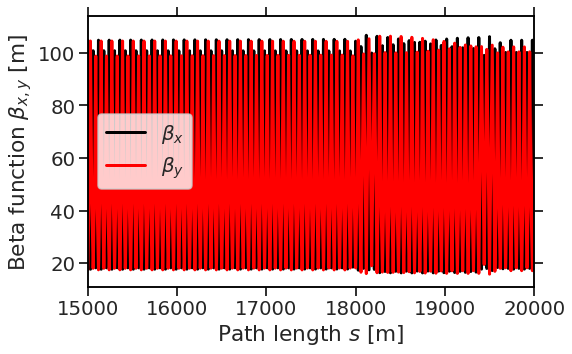

In [160]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='red')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m]')
plt.legend();
plt.xlim(15000,20000)

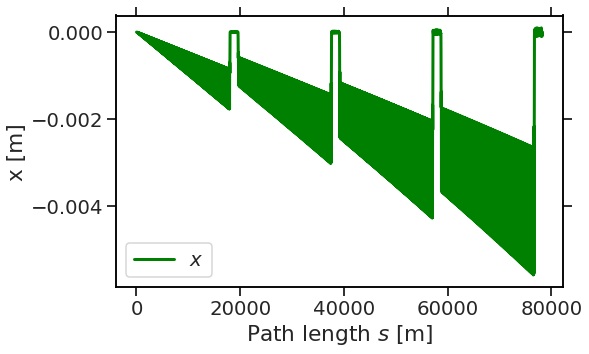

In [161]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['x'], label=r'$x$', color='green')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'x [m]')
plt.legend();
# plt.xlim(65000,55000)

(65000.0, 55000.0)

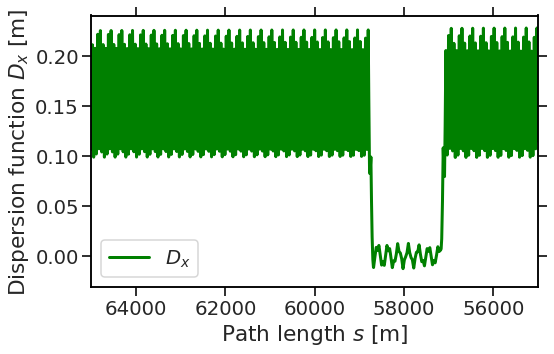

In [162]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['Dx'], label=r'$D_x$', color='green')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Dispersion function $D_x$ [m]')
plt.legend();
plt.xlim(65000,55000)

First we have to match the energy gain in our cavities to make sure we receive as much energy as we lose due to synchrotron radiation:

In [ ]:
madx.input('''
match, sequence=JC_RF;
    vary, name = lgrf, step=1.0E-6;
    constraint, sequence=JC_RF, range = #E, T=0;
    jacobian, calls=30, tolerance=1.E-22, strategy=3;
endmatch;
''')

In [ ]:
madx.twiss();

As a next step we rematch tunes and chromaticities. Since we have a big beta beat, we do not use the complicated matching command from above.

In [ ]:
madx.input('''
match, sequence = JC_RF;
    global, q1=tuneToBeX;
    global, q2=tuneToBeY;
    global, dq1=2;
    global, dq2=2;
    vary, name=k1qfs,  step=1.0E-10 ;  
    vary, name=k1qds,  step=1.0E-10 ;
    vary, name=k2sf,  step=1.0E-10 ;  
    vary, name=k2sd,  step=1.0E-10 ;
    jacobian,calls=20,tolerance=1.e-15,bisec=3;
endmatch;
''')

In [ ]:
twiss = madx.twiss()

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='red')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m]')
plt.legend();
# plt.xlim(15000,20000)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['Dx'], label=r'$D_x$', color='green')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Dispersion function $D_x$ [m]')
plt.legend();
# plt.xlim(65000,75000)

### <span style="color:blue;">d) Observe the transverse orbit. Can you explain the pattern you see?</span>

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['x'], label=r'$x$', color='black')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Horizontal orbit $x$ [m]')
plt.legend();
# plt.xlim(15000,20000)

This effect has already been observed in LEP measurements at the time:

![sawtooth orbit](sawtooth.png)

### <span style="color:blue;">e) Calculate the equilibrium beam parameters with the MAD-X emit command</span>

In [ ]:
madx.emit();

Compare the results from emit with the anaytically calculated values:

In [ ]:
epsilon_x_SRI = C_q*gamma_L**2/J_x*SRI5/SRI2
U0_SRI = 8.846e-5/2/np.pi*ENERGY**4*SRI2 # in GeV
alpha_c_SRI = SRI1/twiss.summary.length
dp_p_SRI = np.sqrt(C_q * gamma_L**2 * SRI3 / (2 * SRI2 + SRI4))
J_x_SRI = 1-SRI4/SRI2
J_s_SRI = 2+SRI4/SRI2

epsilon_x_SRI, U0_SRI, alpha_c_SRI,dp_p_SRI,J_x_SRI,J_s_SRI

### <span style="color:blue;">f) How many particles and bunches can you fill into the ring before you reach the limit of synchrotron radiation power?</span>

$\,$

$\,$

## 5. If time permits: mini-beta insertions


### <span style="color:blue;">a) Calculate the required values for $\beta^*$ or get them from colleagues (groups working on the general parameters topic I).</span>

### <span style="color:blue;">b) Include two mini-beta insertions into your MAD-X model and match the optics.</span>

### <span style="color:blue;">c) How do you distribute the mini-beta insertions and why?</span>